# 2.8	Praxisbeispiel Teil 1: URLs generieren und herunterladen

Im letzten Teil hast du gesehen, wie du strukturierte Daten aus HTML-Dateien extrahieren kannst.

Nun widmen wir uns einem Praxisbeispiel und versuchen, *viele Artikel* des Heise-Newsticker herunterzuladen. Unsere bisherige Lösung würde das bereits erlauben, allerdings kennst du die dazu notwendigen URLs der Artikel nicht.

## Automatische Downloads und `robots.txt` 

Bereits in den Anfangszeiten des Internets wurde an den automatischen Download von Dateien und damit verbundene Probleme gedacht. Daher gibt es den [Robots Exclusion Standard](https://de.wikipedia.org/wiki/Robots_Exclusion_Standard).

Bevor du Daten von Heise herunterlädst, solltest du die die Datei genauer anschauen. Das Paket `advertools` kann diese sehr schön aufbereiten:

In [ ]:
!pip install advertools

In [ ]:
import advertools
robots_df = advertools.robotstxt_to_df('https://www.heise.de/robots.txt')
robots_df

Dürfen wir Artikel unterhalb von `/newsticker/` herunterladen?

In [ ]:
robots_df[robots_df["content"].str.startswith("/newsticker")]

Das sieht sehr gut aus!

## Verzeichnis der Dateien: `sitemap.xml` 

Viele Websites haben ein automatisches erstelltes Verzeichnis aller Dateien, damit sie auch von Suchmaschinen besser gefunden werden können. Die Datei heißt normalerweise `sitemap.xml` und du kannst sie einfach herunterladen. Achtung, die Datei kann sehr, sehr lang sein, daher kann der Download auch ein bisschen dauern:

In [ ]:
sitemap_df = advertools.sitemap_to_df('https://www.heise.de/sitemap.xml')
sitemap_df

Obwohl dies auf den ersten Blick ziemlich umfangreich erscheint, sind *nur* die letzten 10.000 Artikel enthalten. Wir müssen also eine andere Möglichkeit finden, auf die restlichen Artikel zuzugreifen.

## Das Newsticker-Archiv eines Monats

Tatsächlich finden sich alle jemals veröffentlichten Artikel im Newsticker-Archiv. Du findest es als Link auf der Newsticker-Seite oder direkt unter https://www.heise.de/newsticker/archiv

Standardmäßig wird immer die Artikel des aktuellen Monats angezeigt, aber du kannst im Archiv *blättern*. Die Bildungsregel kannst du einfach erraten, es ist immer die URL https://www.heise.de/newsticker/archiv/#{year}/#{month}/

Wir schreiben uns nun eine Funktion, die das Archiv für einen Monat herunterlädt und abspeichert.

In [ ]:
import os
import requests

def archiv_filename(year, month):
    return f"archiv/{year:04}-{month:02}.html"

def download_newsticker_archiv(year, month):
    filename = archiv_filename(year, month)
    if not os.path.isfile(filename):
        r = requests.get(f"https://www.heise.de/newsticker/archiv/{year:04}/{month:02}/")
        open(filename, 'wb').write(r.content)

Am besten lädst du zunächst nur eine Archiv-Datei herunter. Alle Archiv-Dateien legst du in das Verzeichnis `archiv`, das bei Bedarf zunächst anlegst:

In [ ]:
if not os.path.isdir("archiv"):
    os.mkdir("archiv")

download_newsticker_archiv(2020, 12)

 Diese kannst du nun durch `BeautifulSoup` analysieren lassen:

In [ ]:
from bs4 import BeautifulSoup
html = open(archiv_filename(2020, 12)).read()
soup = BeautifulSoup(html)

Mithilfe des *Web Inspectors* findest du einen passenden CSS-Selektor für die Links zu den Artikeln. Dazu wählst du den Text aus und gehst in dem Source-Code etwas nach oben, bis du den `<a>`-Tag findest. 

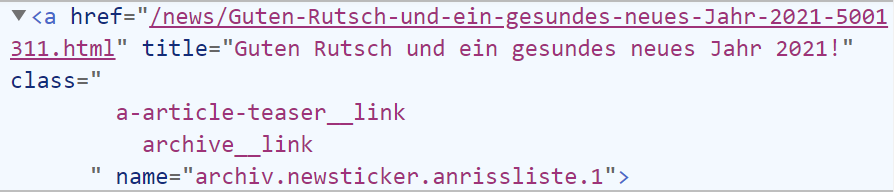

Oft ist es geschickt, zunächst einen auszuwählen:

In [ ]:
soup.select_one("a.a-article-teaser__link")

Alle URLs kannst du generieren, indem du über den Selektor iterierst:

In [ ]:
urls = [a.attrs["href"] for a in soup.select("a.a-article-teaser__link")]
len(urls)

Die Anzahl passt für einen Monat.

## Archiv für ein Jahr herunterladen

Anschließend schreibst du eine Schleife und lädst die Dateien für ein ganzes Jahr herunter. In jeder Iteration extrahierst du die URLs und fügst sie dem URL-Array hinzu:

In [ ]:
urls = []
for year in [2020]:
    for month in range(1, 13):
        download_newsticker_archiv(year, month)
        soup = BeautifulSoup(open(archiv_filename(year, month)).read())
        urls += [a.attrs["href"] for a in soup.select("a.a-article-teaser__link")]

Jetzt kannst du überprüfen, wie viele URLs es geworden sind:

In [ ]:
len(urls)

Einige URLs liegen auf anderen Websites wie TechStage, die möchten wir nicht behalten, sondern nur solche des Newstickers:

In [ ]:
clean_urls = [u for u in urls if u.startswith("/news")]

In [ ]:
len(clean_urls)

Diese URLs kannst du durch Zeilenumbrüche getrennt in einer Textdatei abspeichern.

In [ ]:
import json

open("urls-2020.txt", "w").write("\n".join(clean_urls))